## Import dependencies

In [12]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from sklearn.impute import SimpleImputer
from fancyimpute import KNN, IterativeImputer
import statsmodels.api as sm
from sklearn.cluster import KMeans
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, average_precision_score
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.feature_selection import VarianceThreshold, SelectFromModel, SelectKBest, chi2, f_classif
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, OneHotEncoder


## EXPLORATORY DATA ANALYSIS (EDA)

In [13]:
file_name = "dataset/dataset.pkl"
df = pd.read_pickle(file_name)

In [14]:
print('Size of dataset:',df.shape)

Size of dataset: (34553, 7676)


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34553 entries, 0 to 34552
Columns: 7676 entries, ID to Class
dtypes: category(2), float64(7672), int64(1), object(1)
memory usage: 2.0+ GB


In [16]:
df.describe()

,ID,GR1,GR2,GR3,GR4,GR5,GR6,GR7,GR8,GR9,...,M5,M6,M7,M8,M9,M10,M11,M12,FA1,FA2
count,34553.000000,34553.000000,34553.0,34553.000000,34553.000000,34553.000000,34553.000000,34553.000000,34553.000000,34553.000000,...,34523.000000,34523.000000,34553.000000,34553.000000,34523.000000,34523.000000,34523.000000,34523.000000,34553.000000,34553.000000
mean,17276.000000,468.496657,4000.0,1.514924,1.859518,2.182310,3.225849,0.750017,0.777948,0.041148,...,128.363722,247.769003,93.282986,5111.331086,0.206148,130.609748,127.713064,258.322812,0.408289,3.525943
std,9974.736262,359.995961,0.0,0.919668,0.900306,5.884011,6.855505,0.134974,0.111760,0.123031,...,174.094747,333.070620,114.510746,14795.681144,40.931449,181.403888,178.913344,355.034902,0.427391,2.288027
min,0.000000,38.000000,4000.0,0.000000,0.000000,0.000000,0.000000,0.002335,0.004738,0.000000,...,0.000000,0.160338,0.000000,0.000000,-595.549988,0.002173,0.003245,0.170985,0.025907,0.999756
25%,8638.000000,263.000000,4000.0,0.913038,1.318312,0.000000,2.577457,0.749507,0.772263,0.010573,...,0.596330,1.281167,17.000000,180.000000,-2.467975,1.195450,1.159256,2.449232,0.155951,1.634890
50%,17276.000000,362.000000,4000.0,1.527949,1.851700,2.577457,3.436609,0.787213,0.802178,0.012306,...,58.222885,115.305832,48.000000,744.000000,0.000044,47.875366,46.568928,95.393669,0.285936,3.027393
75%,25914.000000,533.000000,4000.0,2.053427,2.348888,3.422379,4.208969,0.810568,0.822396,0.014757,...,188.489037,363.069061,117.000000,2156.000000,2.919758,193.915451,186.859177,384.038589,0.498833,4.649327
max,34552.000000,1716.000000,4000.0,13.298012,18.258787,911.520630,995.643127,0.924242,0.926606,0.826488,...,1451.364502,2465.521484,1470.000000,180137.000000,575.418274,1167.498657,1105.323120,2020.983765,3.900186,14.356420


### Visualize Missing values/ Data Distribution

In [33]:
plt.figure(figsize=(100,100))
sns.heatmap(df[:].isnull(), cmap='viridis')
plt.savefig('figures/missing_values_heatmap.png')

### Drop columns with too many missing values (>70%)

In [34]:
# get the list of columns with more than 70% missing values
NAN_VAL_THRESHOLD = 0.7
missing_cols = df.columns[df.isnull().sum() / df.shape[0] > NAN_VAL_THRESHOLD]
print(f'Lenght of columns with more than {int(NAN_VAL_THRESHOLD*100)}% missing values: {len(missing_cols)}')
# Drop columns with too many missing values (>70%)
df = df.dropna(axis=1, thresh=int(NAN_VAL_THRESHOLD*len(df)))
print('Size of dataset:',df.shape)

Lenght of columns with more than 70% missing values: 116
Size of dataset: (34552, 7386)


### Convert the Target column to numerical labels

In [35]:
# Convert the class categories to numerical labels
df["Class"] = df["Class"].cat.codes
# Define X, y 
X = df.drop(columns=['Class','ID','Group','Time'], axis=1)
y = df['Class']

<ipython-input-35-f5b6e83a4a08>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Class"] = df["Class"].cat.codes


### Drop Columns with Low Variance

In [38]:
# Drop columns with low variance
sel = VarianceThreshold(threshold=(.8 * (1 - .8))) 
X_tr = sel.fit_transform(X)
X_tr = pd.DataFrame(data=X_tr)

### Split the dataset into Train and Testing

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X_tr, y, test_size=0.2, random_state=42, stratify=y)

In [44]:
y_train.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)
X_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)

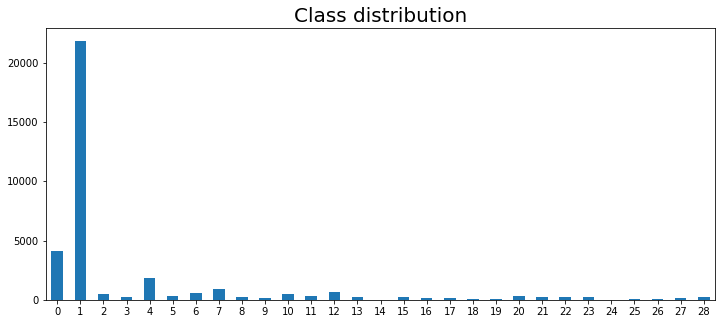

In [45]:
import matplotlib.pyplot as plt
import pandas as pd
df['Class'].value_counts().sort_index().plot(kind='bar', figsize=(12,5), log=False)
plt.title('Class distribution', fontsize=20)
plt.xticks(rotation=0)
plt.show()

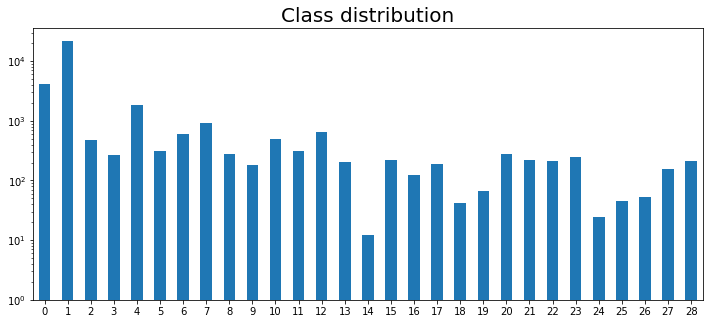

In [46]:
df['Class'].value_counts().sort_index().plot(kind='bar', figsize=(12,5), log=True)
plt.title('Class distribution', fontsize=20)
plt.xticks(rotation=0)
plt.show()

### Feature Scaling (Impute, Standardization)

In [47]:
# TRY FANCY IMPUTATION METHODS (e.g. SimpleImputer)
# https://pypi.org/project/fancyimpute/
# https://towardsdatascience.com/imputation-in-python-with-fancyimpute-and-pandas-b8f8f8f8f8
pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

X_train_tr = pipeline.fit_transform(X_train)
X_test_tr = pipeline.fit_transform(X_test)

In [48]:
print('Size of dataset:',X_test_tr.shape)
print('Size of dataset:',X_test.shape)

print('Size of dataset:',X_train.shape)
print('Size of dataset:',X_train_tr.shape)

Size of dataset: (6911, 4904)
Size of dataset: (6911, 4904)
Size of dataset: (27641, 4904)
Size of dataset: (27641, 4904)


In [49]:
#convert X_train_tr to dataframe
X_train_tr = pd.DataFrame(X_train_tr, columns=X_train.columns)
X_test_tr = pd.DataFrame(X_test_tr, columns=X_test.columns)

In [50]:
#any missing values in X_train_tr?
print(X_train_tr.isnull().sum().sum())

0


### Drop Highly correlated Columns

In [51]:
def trimm_correlated(df_in, threshold):
    df_corr = df_in.corr(method='pearson', min_periods=1)
    df_not_correlated = ~(df_corr.mask(np.tril(np.ones([len(df_corr)]*2, dtype=bool))).abs() > threshold).any()
    un_corr_idx = df_not_correlated.loc[df_not_correlated[df_not_correlated.index] == True].index
    df_out = df_in[un_corr_idx]
    return df_out

In [52]:
# XX = trimm_correlated(X_test_tr, 0.8)

### PCA

In [97]:
pca = PCA(n_components=0.8) # 90% of the variance retained
#pca.n_components

In [98]:
pca.fit(X_train_tr)
pca.fit(X_test_tr)
pca_data = pca.transform(X_train_tr)
X_test_pca = pca.transform(X_test_tr)
percentage_variance = np.round(pca.explained_variance_ratio_*100, decimals=1)
labels = ['PC' + str(x) for x in range(1, len(percentage_variance)+1)]

In [99]:
#convert pca_data to dataframe
X_train_pca = pd.DataFrame(pca_data, columns=labels)
X_test_pca = pd.DataFrame(X_test_pca, columns=labels)

In [100]:
print(f'Size of X_train_pca: {X_train_pca.shape}')
print(f'Size of X_test_pca: {X_test_pca.shape}')

Size of X_train_pca: (27641, 92)
Size of X_test_pca: (6911, 92)


In [101]:
# Plot Percentage of Variance by Principal Component
%matplotlib inline
fig = plt.figure(figsize = (20,10))
plt.bar(x= range(1, len(percentage_variance)+1), height=percentage_variance)
plt.xlabel('Principal Component', fontsize=25)
plt.ylabel('Percentage of Variance', fontsize=25)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.title('Percentage of Variance by Principal Component', fontsize = 35)
plt.savefig('pca_plot.png', dpi=500, quality=100, optimize=True, progressive=True  ,bbox_inches = 'tight')
plt.show()

In [102]:
# Plot explained variance
plt.figure(figsize=(20,10))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components', fontsize=25)
plt.ylabel('Cumulative Explained Variance', fontsize=25)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.title('Cumulative Explained Variance by Number of Components', fontsize = 35)
plt.savefig('pca_plot_2.png', dpi=300, quality=100, optimize=True, progressive=True  ,bbox_inches = 'tight')
plt.show()


In [103]:
# kmeans =KMeans(n_clusters=20).fit(X_train_tr)
# pca_data['cluster'] = pd.Categorical(kmeans.labels_)

In [104]:
# fig, ax = plt.subplots(figsize=(40,20))
# sns.scatterplot(x="PC1",y="PC2",hue="cluster",data=pca_data)
# #change figure size
# #save fig
# plt.savefig('15_pca_plot_cluster.png', dpi=500, quality=100, optimize=True, progressive=True  ,bbox_inches = 'tight')

### Lasso CV 

### RFD

In [105]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFECV

In [106]:
# pca_data.drop(['cluster'], axis=1, inplace=True)

## Train XGBOOST

In [107]:
import xgboost as xgb

In [108]:
#import precision score
from sklearn.metrics import precision_score, accuracy_score, recall_score, f1_score, confusion_matrix, classification_report

def train_xgboost(X,y,X_test,y_test):
    xgb_model = xgb.XGBClassifier(max_depth=3, n_estimators=100, learning_rate=0.1)
    xgb_model.fit(X,y)
    y_pred = xgb_model.predict(X_test)
    # print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
    # print(f'Recall: {recall_score(y_test, y_pred)}')
    # print(f'Precision: {precision_score(y_test, y_pred)}')
    # print(f'F1 score: {f1_score(y_test, y_pred)}')
    # print(f'Confusion matrix: \n{confusion_matrix(y_test, y_pred)}')
    # print(f'Classification report: \n{classification_report(y_test, y_pred)}')
    return xgb_model, y_pred

In [109]:
xgb_model, y_pred = train_xgboost(X_train_pca, y_train, X_test_pca, y_test)

In [110]:
print(accuracy_score(y_test, y_pred))

0.90450007234843


## Evaluation Metrics

<ipython-input-112-c77198036bce>:4: RuntimeWarning: invalid value encountered in true_divide
  cm_normalized = (cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]).round(2)


<AxesSubplot:title={'center':'Evaluation on Test Dataset'}>

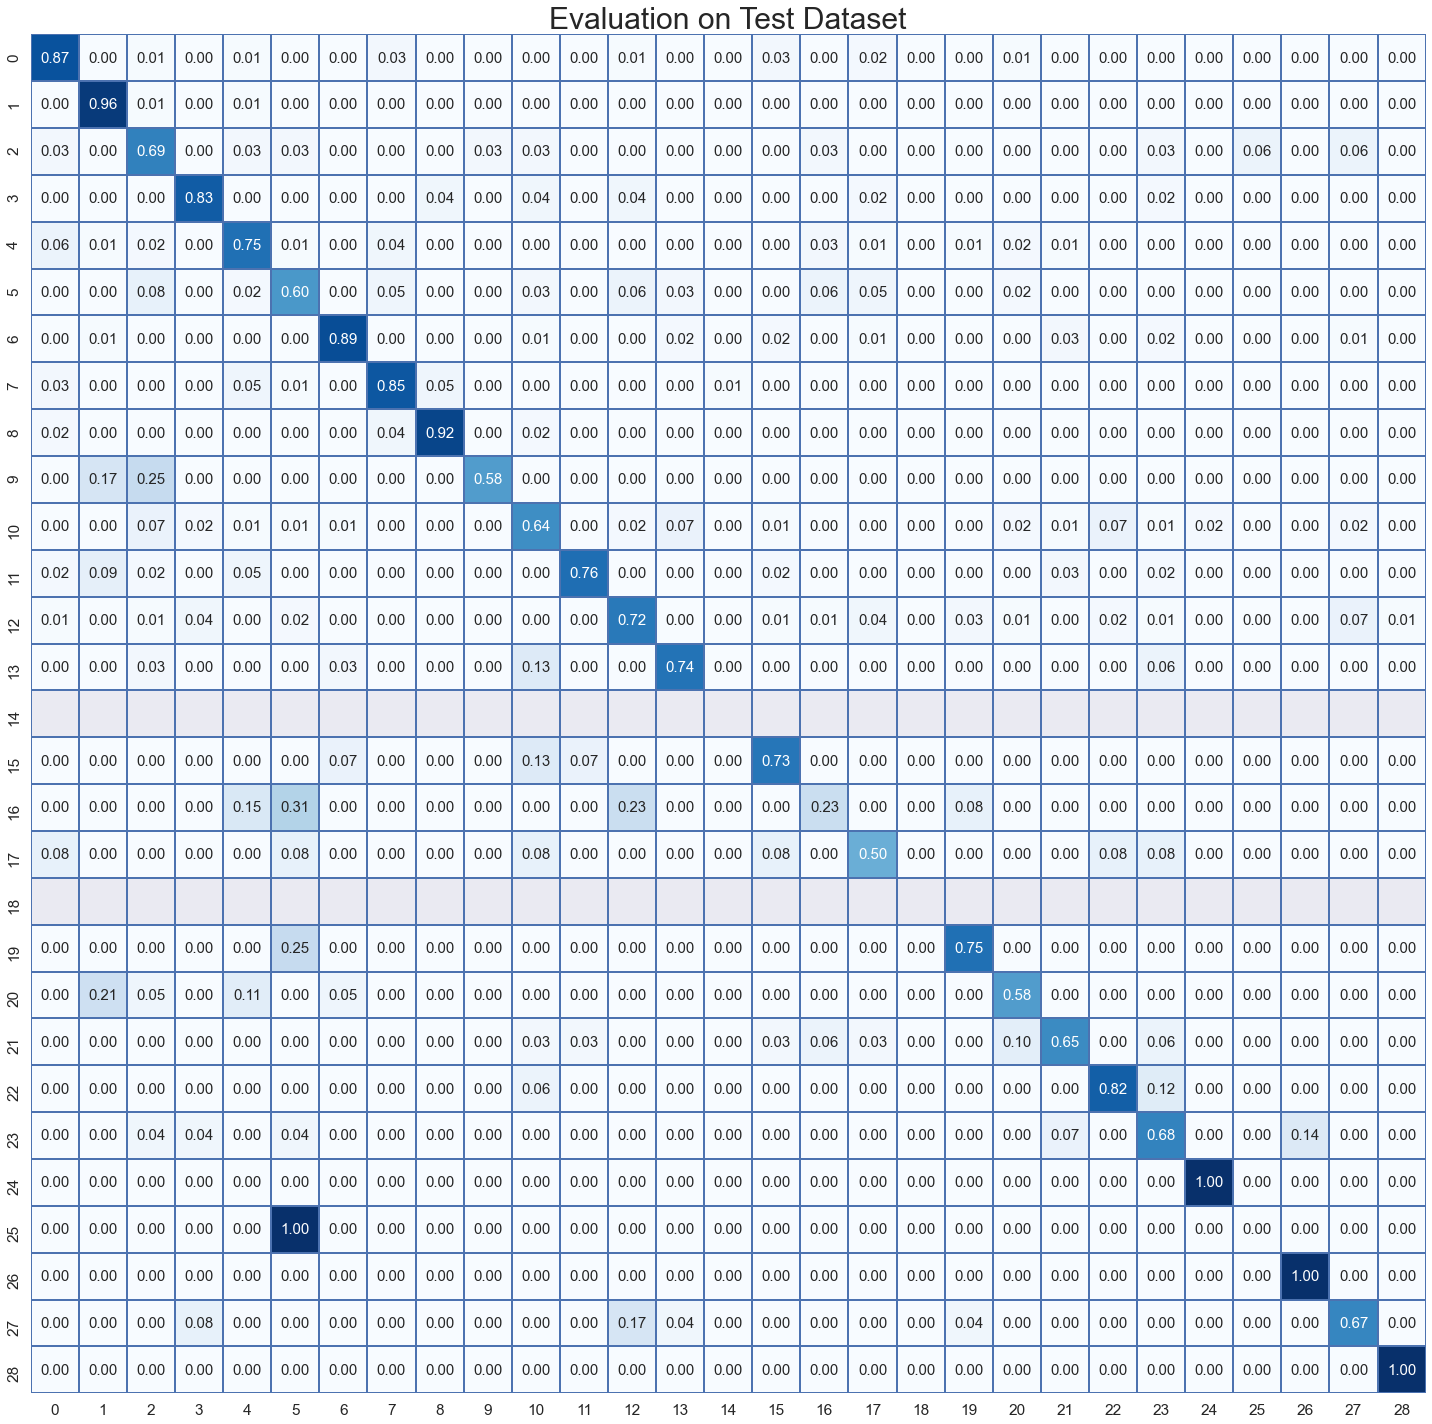

In [112]:
from sklearn import metrics
cm = metrics.confusion_matrix(y_pred, y_test)
#normalize the confusion matrix
cm_normalized = (cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]).round(2)
plt.figure(figsize=(25,25))
sns.set(font_scale=1.4)
#set title and labels
plt.title("Evaluation on Test Dataset", size=30)
plt.xlabel("Predicted Label", size=20)
plt.ylabel("True Label", size=20)
#plot the confusion matrix
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap="Blues", annot_kws={"size": 15},linewidths=2, linecolor='b', cbar=False)

In [ ]:
# pd.crosstab(y_test, y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

In [111]:
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.87      0.96      0.91       824
           1       0.96      1.00      0.98      4369
           2       0.69      0.25      0.36        97
           3       0.83      0.77      0.80        52
           4       0.75      0.85      0.79       369
           5       0.60      0.60      0.60        62
           6       0.89      0.87      0.88       119
           7       0.85      0.71      0.77       181
           8       0.92      0.82      0.87        55
           9       0.58      0.39      0.47        36
          10       0.64      0.79      0.71        99
          11       0.76      0.71      0.73        62
          12       0.72      0.78      0.75       129
          13       0.74      0.56      0.64        41
          14       0.00      0.00      0.00         2
          15       0.73      0.25      0.37        44
          16       0.23      0.12      0.16        25
          17       0.50    

c:\Users\Mahmu\anaconda3\envs\faa_env\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Mahmu\anaconda3\envs\faa_env\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Mahmu\anaconda3\envs\faa_env\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
